# Word Graph

In [7]:
!pip install PyPDF2 nltk networkx pandas matplotlib tqdm
import os, re, math
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
import PyPDF2
import re
import nltk
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

nltk.download("punkt")  # sekali saja

# --- baca PDF ---
def read_pdf(path):
    pages = []
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for p in reader.pages:
            t = p.extract_text()
            if t:
                pages.append(t)
    return "\n".join(pages)

# GANTI path kalau perlu
pdf_text = read_pdf("Data/Papper_Gempa.pdf")

print("Panjang teks mentah:", len(pdf_text))
print(pdf_text[:500])


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Panjang teks mentah: 22087
 
DRR Action Plan Workshop: Strengthened Indonesian  
Resilience: Reducing Risk from Disasters  
 
 
Bencana  Gempabumi  
Salahuddin Husein  
Depart emen Teknik Geologi , Fakultas Teknik, Universitas Gadjah Mada  
email: shddin @gmail.com  
 
Abstract:   
Bencana gempabumi di Indonesia adalah suatu keniscayaan, tidak hanya pada daerah 
yang selama ini diketahui seringkali mengalaminya, namun juga pada daerah yang dahulu diduga 
relatif aman. Kondisi demikian dikontrol oleh konfigurasi tektonis I


In [15]:
from nltk.tokenize import word_tokenize

def clean_text(text):
    # buang bagian referensi kalau ada
    cut = re.search(r"(DAFTAR PUSTAKA|REFERENSI|References|Bibliographie)",
                    text, re.IGNORECASE)
    if cut:
        text = text[:cut.start()]
    # rapikan spasi
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned = clean_text(pdf_text)

print("Panjang teks cleaned:", len(cleaned))
print(cleaned[:500])

# --- tokenisasi kata: jaga urutan! ---
tokens = word_tokenize(cleaned.lower())

# ambil hanya huruf (buang angka/tanda baca)
words = [re.sub(r"[^a-zA-Z]", "", w) for w in tokens]
words = [w for w in words if w != ""]  # buang string kosong

print("Total kata:", len(words))
print("20 kata pertama:", words[:20])


Panjang teks cleaned: 20927
DRR Action Plan Workshop: Strengthened Indonesian Resilience: Reducing Risk from Disasters Bencana Gempabumi Salahuddin Husein Depart emen Teknik Geologi , Fakultas Teknik, Universitas Gadjah Mada email: shddin @gmail.com Abstract: Bencana gempabumi di Indonesia adalah suatu keniscayaan, tidak hanya pada daerah yang selama ini diketahui seringkali mengalaminya, namun juga pada daerah yang dahulu diduga relatif aman. Kondisi demikian dikontrol oleh konfigurasi tektonis Indonesia di masa lampa u d
Total kata: 2750
20 kata pertama: ['drr', 'action', 'plan', 'workshop', 'strengthened', 'indonesian', 'resilience', 'reducing', 'risk', 'from', 'disasters', 'bencana', 'gempabumi', 'salahuddin', 'husein', 'depart', 'emen', 'teknik', 'geologi', 'fakultas']


In [16]:
from itertools import zip_longest

G = nx.Graph()

# tambahkan node
for w in words:
    if not G.has_node(w):
        G.add_node(w)

# tambahkan edge untuk pasangan bertetangga (distance = 1)
for w1, w2 in zip(words, words[1:]):
    if w1 == "" or w2 == "":
        continue
    if G.has_edge(w1, w2):
        # boleh pakai weight kalau mau tahu seberapa sering
        G[w1][w2]["weight"] += 1
    else:
        G.add_edge(w1, w2, weight=1)

print("Jumlah node (kata unik):", G.number_of_nodes())
print("Jumlah edge (pasangan tetangga):", G.number_of_edges())


Jumlah node (kata unik): 885
Jumlah edge (pasangan tetangga): 2243


In [17]:
from collections import Counter

# hitung frekuensi kata untuk pilih N terbesar
freq = Counter(words)
N = 20   # ubah kalau mau 30 / 50 kata, dsb

# ambil N kata paling sering
top_vocab = [w for w, c in freq.most_common(N)]
print("Kata yang dipakai di matriks:", top_vocab)

# buat indeks
idx = {w: i for i, w in enumerate(top_vocab)}

# inisialisasi matriks 0
A = np.zeros((N, N), dtype=int)

# isi matriks: kalau ada edge di graph → 1
for u, v in G.edges():
    if u in idx and v in idx:
        i, j = idx[u], idx[v]
        A[i, j] = 1
        A[j, i] = 1   # graph tak berarah

adj_df = pd.DataFrame(A, index=top_vocab, columns=top_vocab)
adj_df


Kata yang dipakai di matriks: ['yang', 'dan', 'gempabumi', 'gelombang', 'di', 'patahan', 'pada', 'bangunan', 'dengan', 'untuk', 'dapat', 'batuan', 'oleh', 'akan', 'besar', 'dalam', 'bidang', 'tidak', 'perioda', 'ini']


,yang,dan,gempabumi,gelombang,di,patahan,pada,bangunan,dengan,untuk,dapat,batuan,oleh,akan,besar,dalam,bidang,tidak,perioda,ini
yang,0,0,1,1,0,1,0,1,1,0,1,1,0,0,1,0,0,1,1,0
dan,0,0,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1,0
gempabumi,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,0,1,0,0
gelombang,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
di,0,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0
patahan,1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0
pada,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
bangunan,1,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
dengan,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0
untuk,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [18]:
pr = nx.pagerank(G, weight="weight")  # pakai bobot berapa sering jadi tetangga

# urutkan dari yang terbesar
pr_sorted = sorted(pr.items(), key=lambda x: x[1], reverse=True)

# tampilkan 20 kata terpenting
top_pr = pr_sorted[:20]
pr_df = pd.DataFrame(top_pr, columns=["Kata", "PageRank"])
pr_df


,Kata,PageRank
0,yang,0.030082
1,dan,0.024787
2,gempabumi,0.020449
3,gelombang,0.017071
4,patahan,0.014807
5,di,0.014778
6,pada,0.009772
7,bangunan,0.008228
8,untuk,0.007067
9,dapat,0.006904


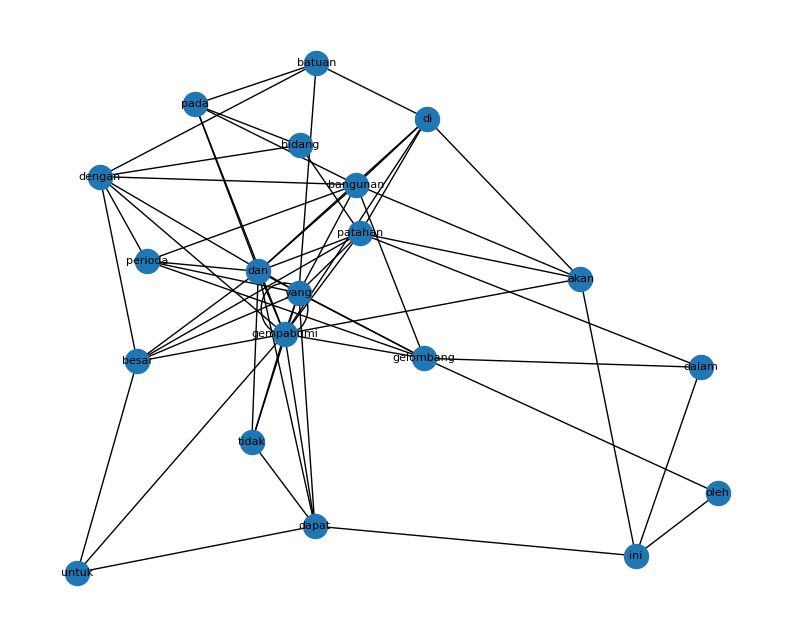

In [19]:
plt.figure(figsize=(10, 8))

subG = G.subgraph(top_vocab)
pos = nx.spring_layout(subG, k=0.4)

nx.draw_networkx_nodes(subG, pos)
nx.draw_networkx_edges(subG, pos)
nx.draw_networkx_labels(subG, pos, font_size=8)

plt.axis("off")
plt.show()
